In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import run_streamer
%pylab notebook
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [3]:
def calculate_combined(table):
    table['COMBINEDup'] = table.ix[:,('LWup','SWup')].sum(axis=1)
    table['COMBINEDdown'] = table.ix[:,('LWdown','SWdown')].sum(axis=1)
    return table.ix[:,('COMBINEDup','COMBINEDdown','net')]

In [4]:
def get_table(name, band, **user_settings):
    settings = {'Tropical':run_streamer.TROPICAL, 'Arctic':run_streamer.ARCTIC}[name].copy()
    settings.update({'SW':run_streamer.SW,'LW':run_streamer.LW,'COMBINED':run_streamer.COMBINED}[band])
    settings.update(user_settings)
    table = run_streamer.run_and_parse('./streamer','./template.inp',**settings)[0]
    table = table.ix[[100,0]]
    table.index = ['TOA','SFC']
    if band == 'COMBINED':
        table = calculate_combined(table)
    table.columns = pd.MultiIndex.from_product([[name],table.columns])
    table = table.rename(columns={'net':(band+'net')})
    return table.ix[:,[(name,band+'up'),(name,band+'down'),(name,band+'net')]]

In [5]:
def get_spectral_flux(name, level, **user_settings):
    settings = {'Tropical':run_streamer.TROPICAL, 'Arctic':run_streamer.ARCTIC}[name].copy()
    settings.update(run_streamer.SPECTRAL)
    settings.update(user_settings)
    tables = run_streamer.run_and_parse('./streamer','./template.inp',**settings)
    bandwidth = lambda x: abs(1/(x[0]*100.)*1e6 - 1/(x[1]*100.)*1e6)
    spectral_flux = pd.DataFrame([{'up':(table.ix[level,'LWup']+table.ix[level,'SWup'])/bandwidth(band),
                                   'down':(table.ix[level,'LWdown']+table.ix[level,'SWdown'])/bandwidth(band),
                                   'net':table.ix[level,'net']/bandwidth(band)
                                  } for band, table in zip(run_streamer.BANDS,tables)],
                                index=[1e6/(sum(band)/2.0*100) for band in run_streamer.BANDS])
    spectral_flux[:] = spectral_flux.values * spectral_flux.index[:,np.newaxis]
    return spectral_flux

In [6]:
def plot_flux(sfc_flux, toa_flux):

    sfc_flux.sort_index(inplace=True)
    sfc_flux.up *= -1
    sfc_flux.ix[:,('down','up')].rename(columns=lambda x: 'SFC '+x).plot(
        #kind='area',
        linestyle='--',
        logx=True,
        color='r',
        stacked=False)
    sfc_flux.net.plot(kind='area',ax=gca(), color='darkred', legend=True,stacked=False)

    toa_flux.sort_index(inplace=True)
    toa_flux.up *= -1
    toa_flux.ix[:,('down','up')].rename(columns=lambda x: 'TOA '+x).plot(
        #kind='area',
        linestyle='--',
        logx=True,
        color='b',
        stacked=False,
        ax=gca())
    toa_flux.net.plot(kind='area',ax=gca(), linewidth=3, color='darkblue', legend=True, stacked=False)

    xlim([.28,100])
    ylim([-400,400])
    ylabel('$\lambda F_{\lambda}$ [W m$^{-2}$]')
    xlabel('Wavelength [$\mu$m]')
    gca().set_xticks([.28,.6,1,2,5,10,20,50,100])
    gca().set_xticklabels([.28,.6,1,2,5,10,20,50,100])

In [7]:
def get_heating(name, **user_settings):
    band_heatings = []
    settings = {'Tropical':run_streamer.TROPICAL, 'Arctic':run_streamer.ARCTIC}[name].copy()
    settings.update(user_settings)
    for band in ['SW','LW','COMBINED']:
        settings.update({'SW':run_streamer.SW,'LW':run_streamer.LW,'COMBINED':run_streamer.COMBINED}[band])
        table = run_streamer.run_and_parse('./streamer','./template.inp',**settings)[0]
        heating_rate = table.heating_rate.ix[:1]
        heating_rate.name = band+'Heating'
        band_heatings.append(heating_rate)
    return pd.DataFrame(band_heatings).T

In [8]:
def plot_heating(name, **settings):
    heating = get_heating(name, **settings)
    plot(heating.SWHeating.values, heating.SWHeating.index, label='SW')
    plot(heating.LWHeating.values, heating.LWHeating.index, label='LW')
    plot(heating.COMBINEDHeating.values, heating.COMBINEDHeating.index, label='Net')
    ylim([0,50])
    xlim([-7,3])
    vlines(0, *ylim())
    legend(loc='best')
    title(name+' Heating Rate')
    ylabel('Height (km)')
    grid()
    xlabel('Heating Rate ($\degree$K/day)')

In [9]:
def get_spectral_heating(name, **user_settings):
    settings = {'Tropical':run_streamer.TROPICAL, 'Arctic':run_streamer.ARCTIC}[name].copy()
    settings.update(run_streamer.SPECTRAL)
    settings.update(user_settings)
    bandwidth = lambda x: abs(1/(x[0]*100.)*1e6 - 1/(x[1]*100.)*1e6)
    tables = run_streamer.run_and_parse('./streamer','./template.inp',**settings)
    spectral_heating = pd.DataFrame([table.heating_rate / bandwidth(band) 
                                     for band, table in zip(run_streamer.BANDS, tables)],
                                index=[1e6/(sum(band)/2.0*100) for band in run_streamer.BANDS])
    return spectral_heating.T

In [10]:
def plot_spectral_heating(name, **settings):
    heating = get_spectral_heating(name, **settings).sort_index().sort_index(axis=1).ix[:50,.3:50]
    contourf(heating.columns.values, heating.index.values, heating.values,100,cmap='coolwarm')
    gca().set_xscale("log")
    gca().set_xticks([.3,.6,1,2,5,10,20,50])
    gca().set_xticklabels([.3,.6,1,2,5,10,20,50])
    title(name+' Heating Rate [K/day/$\mu m$]')
    ylabel('Z (km)')
    xlabel('Wavelength [$\mu m$]')
    colorbar()

# Tropical
### SW

In [38]:
get_table('Tropical','SW')

Tropical                
        SWup  SWdown   SWnet
TOA    125.0  450.83  325.83
SFC     70.9  304.04  233.15

### LW

In [40]:
get_table('Tropical','LW')

Tropical                
        LWup  LWdown   LWnet
TOA   290.06    0.00 -290.06
SFC   458.22  395.98  -62.24

### Combined

In [42]:
get_table('Tropical','COMBINED')

Tropical                         
    COMBINEDup COMBINEDdown COMBINEDnet
TOA     415.06       450.83       35.77
SFC     529.12       700.02      170.91

### Spectral Flux

<IPython.core.display.Javascript object>


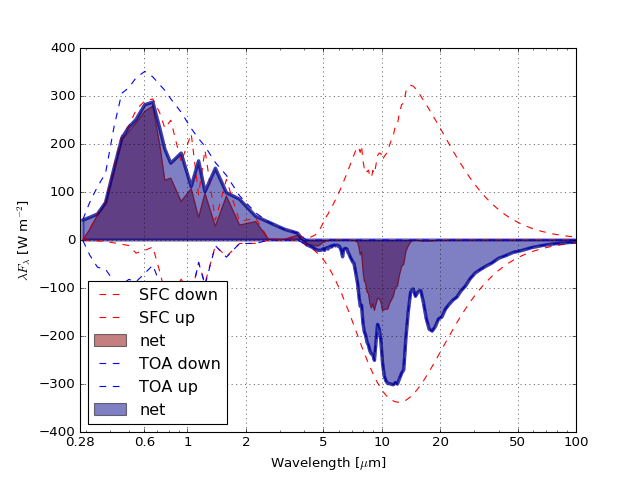

In [40]:
plot_flux(get_spectral_flux('Tropical',0), get_spectral_flux('Tropical',100))

### Heating Rates

<IPython.core.display.Javascript object>


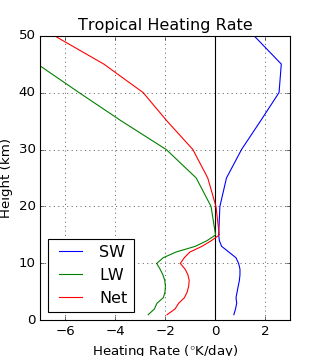

In [268]:
plot_heating('Tropical')

### Spectral Heating Rates

<IPython.core.display.Javascript object>


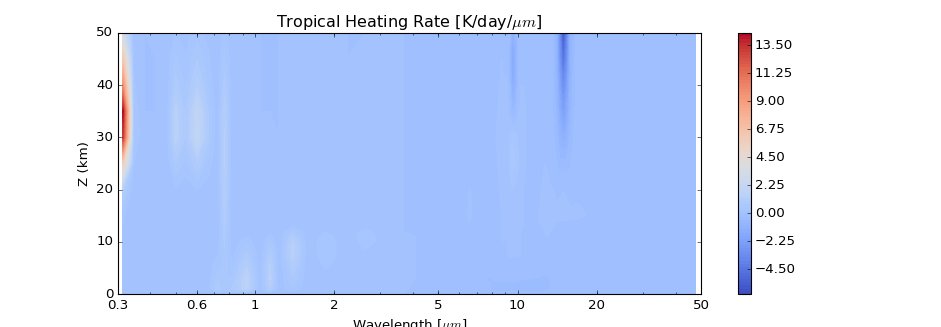

In [255]:
plot_spectral_heating('Tropical')

# Arctic
### SW

In [44]:
get_table('Arctic','SW')

Arctic               
      SWup  SWdown  SWnet
TOA  57.98  144.74  86.76
SFC  21.15   81.99  60.84

### LW

In [46]:
get_table('Arctic','LW')

Arctic                
       LWup  LWdown   LWnet
TOA  170.99    0.00 -170.99
SFC  194.25  134.55  -59.70

### Combined

In [48]:
get_table('Arctic','COMBINED')

Arctic                         
    COMBINEDup COMBINEDdown COMBINEDnet
TOA     228.97       144.74      -84.23
SFC     215.40       216.54        1.14

### Spectral Flux

<IPython.core.display.Javascript object>


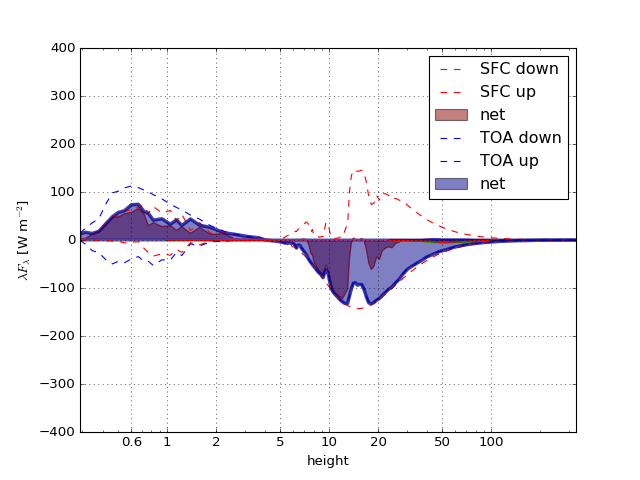

In [41]:
plot_flux(get_spectral_flux('Arctic',0), get_spectral_flux('Arctic',100))

### Heating Rates

<IPython.core.display.Javascript object>


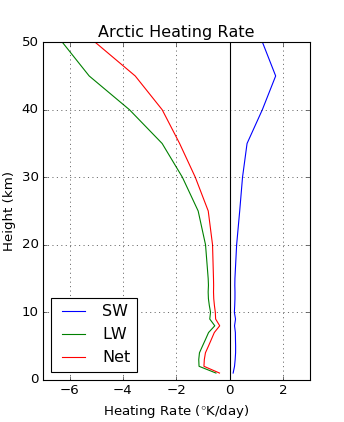

In [265]:
plot_heating('Arctic')

### Spectral Heating Rates

<IPython.core.display.Javascript object>


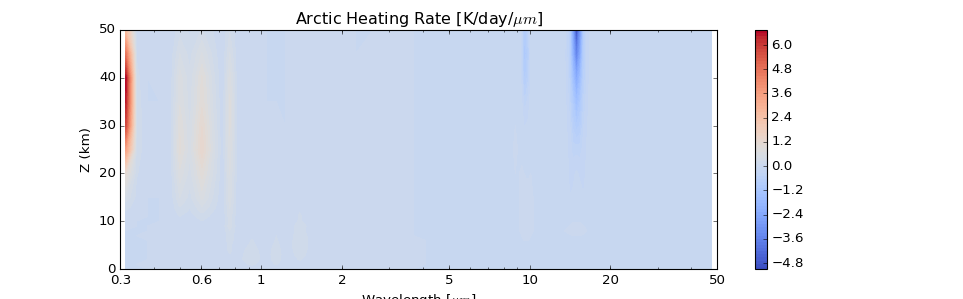

In [254]:
plot_spectral_heating('Arctic')

## 3
Radiative forcing is defined as the change in radiative flux that results from making a particular change to the atmosphere.  For both the tropical atmosphere and the polar atmosphere, repeat the above calculations, but with the following changes each made in turn:
1. 10% increase in water vapor amount everywhere in the column. This means simultaneously increasing both the WV and the WV continuum parameters.
2. Double CO2 concentration.
3. 50% reduction in ozone concentration.
4. Add liquid water cloud layer (cloudphase1 = 0 ) with optical thickness 10.0 and base at 1.0 km.
4. Same as above, but moving the cloud layer to 10.0 km and changing the cloud particle type to “spherical ice”  (cloudphase1 = 8 )


For each of the above changes, plot or tabulate the associated changes (relative to the baseline case) in the fluxes and heating profiles. NOTE: For cloud experiments you will need to make the following changes to your input file:
Change icthk (second to last value in the 13th input line) to 3, so that cloud thickness is specified in optical units.
Change cldwcl (last element in the cloud properties line) to 0.07 to ensure that cloud water density remains within the allowable range for both the low and high cloud layer.

# Increase water vapor 10%
## Arctic

### SW

In [261]:
get_table('Arctic','SW',frwv=1.1, frwv2=1.1) - get_table('Arctic','SW')

Arctic             
      SWup SWdown SWnet
TOA  -0.12   0.00  0.13
SFC  -0.10  -0.28 -0.18

### LW

In [269]:
get_table('Arctic','LW',frwv=1.1, frwv2=1.1) - get_table('Arctic','LW')

Arctic             
      LWup LWdown LWnet
TOA  -0.32   0.00  0.32
SFC   0.00   1.32  1.31

### Combined

In [270]:
get_table('Arctic','COMBINED',frwv=1.1, frwv2=1.1) - get_table('Arctic','COMBINED')

Arctic                         
    COMBINEDup COMBINEDdown COMBINEDnet
TOA      -0.44         0.00        0.45
SFC      -0.10         1.04        1.13

<IPython.core.display.Javascript object>


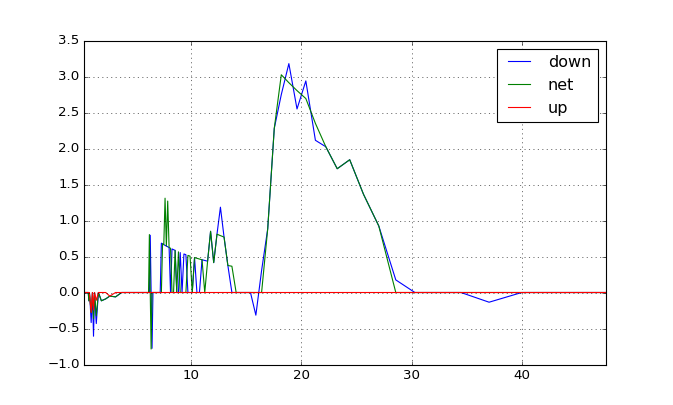

In [280]:
(get_spectral_flux('Arctic',0,frwv=1.1,frwv2=1.1) - get_spectral_flux('Arctic',0)).sort_index().ix[:50].plot()

# Double CO2 Concentration

### SW

In [284]:
get_table('Arctic','SW',frco2=2.0) - get_table('Arctic','SW')

Arctic             
      SWup SWdown SWnet
TOA  -0.07   0.00  0.08
SFC  -0.06  -0.26 -0.21

### LW

In [285]:
get_table('Arctic','LW',frco2=2.0) - get_table('Arctic','LW')

Arctic             
      LWup LWdown LWnet
TOA  -0.87   0.00  0.87
SFC   0.00   1.77  1.77

### Combined

In [286]:
get_table('Arctic','COMBINED',frco2=2.0) - get_table('Arctic','COMBINED')

Arctic                         
    COMBINEDup COMBINEDdown COMBINEDnet
TOA      -0.94         0.00        0.95
SFC      -0.06         1.51        1.56

<IPython.core.display.Javascript object>


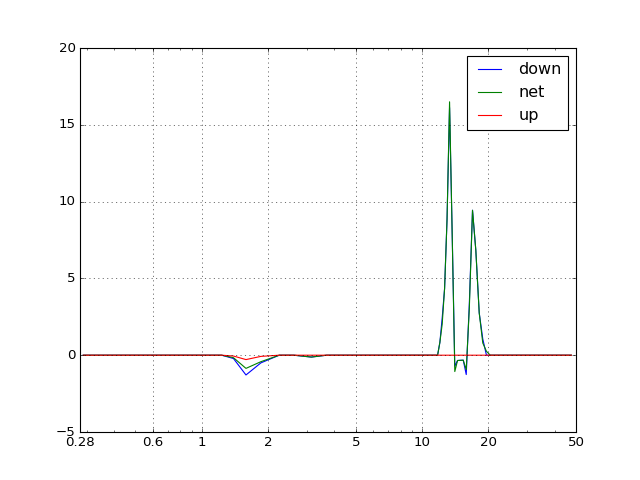

In [296]:
(get_spectral_flux('Arctic',0,frco2=2.0) - get_spectral_flux('Arctic',0)).sort_index().ix[:50].plot()
gca().set_xscale("log")
gca().set_xticks([.28,.6,1,2,5,10,20,50])
_ = gca().set_xticklabels([.28,.6,1,2,5,10,20,50])

# Reduce O3 by 50%

### SW

In [297]:
get_table('Arctic','SW',fro3=0.5) - get_table('Arctic','SW')

Arctic             
      SWup SWdown SWnet
TOA   0.91   0.00 -0.91
SFC   0.07   1.01  0.95

### LW

In [298]:
get_table('Arctic','LW',fro3=0.5) - get_table('Arctic','LW')

Arctic             
      LWup LWdown LWnet
TOA   0.71   0.00 -0.71
SFC   0.00  -0.86 -0.87

### Combined

In [1]:
get_table('Arctic','COMBINED',fro3=0.5) - get_table('Arctic','COMBINED')

NameError: name 'get_table' is not defined

<IPython.core.display.Javascript object>


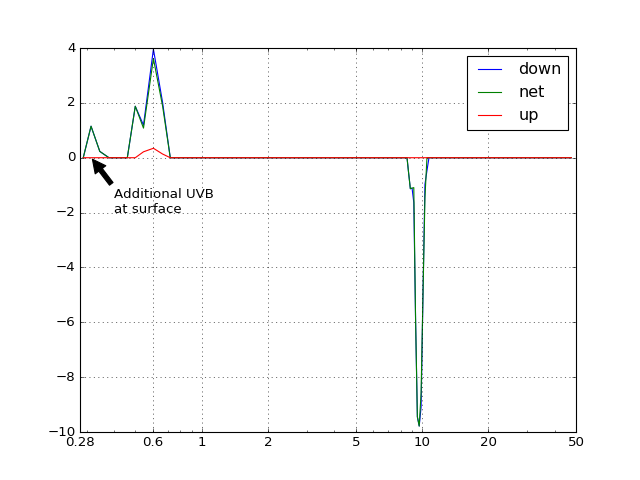

In [306]:
(get_spectral_flux('Arctic',0,fro3=0.5) - get_spectral_flux('Arctic',0)).sort_index().ix[:50].plot()
gca().set_xscale("log")
gca().set_xticks([.28,.6,1,2,5,10,20,50])
_ = gca().set_xticklabels([.28,.6,1,2,5,10,20,50])
annotate('Additional UVB\nat surface', xy=(.315, 0), xytext=(.4, -2),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

# Add liquid water cloud layerwith optical thickness 10.0 and base at 1.0 km

In [22]:
cloud_settings = dict(nclouds=1, icthk=3, cldwcl=0.07, cldphase1=0, cldtau=10.0, cldtop=1.0)

### SW

In [23]:
(get_table('Arctic','SW', **cloud_settings) 
 - get_table('Arctic','SW'))

Arctic              
      SWup SWdown  SWnet
TOA  35.27   0.00 -35.26
SFC -12.40 -47.99 -35.60

### LW

In [24]:
(get_table('Arctic','LW',**cloud_settings) 
 - get_table('Arctic','LW'))

Arctic              
      LWup LWdown  LWnet
TOA   8.31   0.00  -8.31
SFC   0.00  77.48  77.48

### Combined

In [25]:
(get_table('Arctic','COMBINED',**cloud_settings) 
 - get_table('Arctic','COMBINED'))

Arctic                         
    COMBINEDup COMBINEDdown COMBINEDnet
TOA      43.58         0.00      -43.57
SFC     -12.40        29.49       41.88

<IPython.core.display.Javascript object>


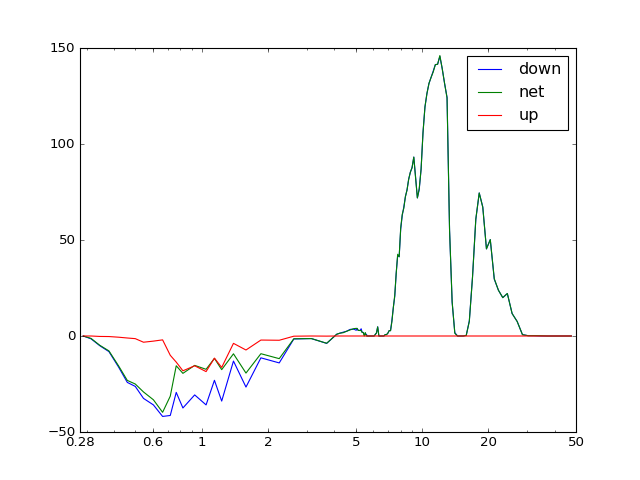

In [28]:
(get_spectral_flux('Arctic',0,**cloud_settings) 
 - get_spectral_flux('Arctic',0)).sort_index().ix[:50].plot()
gca().set_xscale("log")
gca().set_xticks([.28,.6,1,2,5,10,20,50])
_ = gca().set_xticklabels([.28,.6,1,2,5,10,20,50])

# Moving the cloud layer to 10.0 km and changing the cloud particle type to “spherical ice”

In [29]:
cloud_settings = dict(nclouds=1, icthk=3, cldwcl=0.07, cldphase1=8, cldtau=10.0, cldtop=10.0)

### SW

In [30]:
(get_table('Arctic','SW', **cloud_settings) 
 - get_table('Arctic','SW'))

Arctic              
      SWup SWdown  SWnet
TOA  43.00   0.00 -43.00
SFC -11.97 -46.62 -34.65

### LW

In [31]:
(get_table('Arctic','LW',**cloud_settings) 
 - get_table('Arctic','LW'))

Arctic              
      LWup LWdown  LWnet
TOA  -51.8   0.00  51.80
SFC    0.0  36.11  36.11

### Combined

In [32]:
(get_table('Arctic','COMBINED',**cloud_settings) 
 - get_table('Arctic','COMBINED'))

Arctic                         
    COMBINEDup COMBINEDdown COMBINEDnet
TOA      -8.80         0.00        8.80
SFC     -11.97       -10.51        1.46

<IPython.core.display.Javascript object>


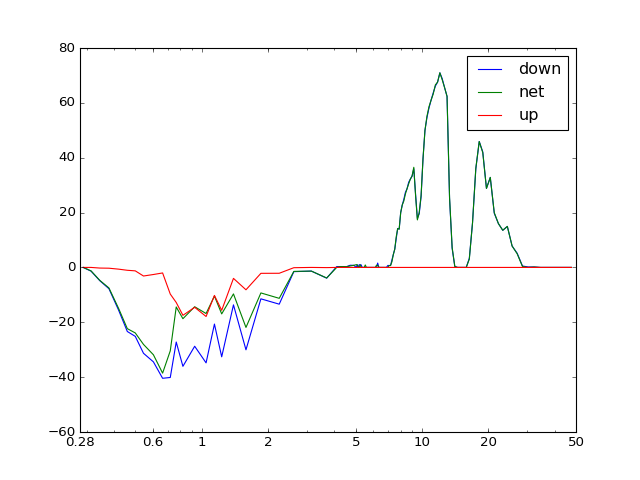

In [33]:
(get_spectral_flux('Arctic',0,**cloud_settings) 
 - get_spectral_flux('Arctic',0)).sort_index().ix[:50].plot()
gca().set_xscale("log")
gca().set_xticks([.28,.6,1,2,5,10,20,50])
_ = gca().set_xticklabels([.28,.6,1,2,5,10,20,50])